## Makemore Part 2: Sugested Exercises

### Ex1 - Improving Andrej's results (2.17 loss on dev set)

My Strategy: Create a class for the neural net so that I can easily try out different parameters

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class NeuralNet:

    def __init__(self, HidNeurons, EmbDim, batch_size, lrevolution, block_size, words):
        # mappings
        chars = sorted(list(set(''.join(words))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        # building the dataset
        def build_dataset(words):  
            X, Y = [], []
            for w in words:
                context = [0] * block_size
                for ch in w + '.':
                    ix = self.stoi[ch]
                    X.append(context)
                    Y.append(ix)
                    context = context[1:] + [ix] # crop and append
            X = torch.tensor(X)
            Y = torch.tensor(Y)
            return X, Y


        # splitting the data onto train, dev and test sets
        import random
        random.seed(42)
        random.shuffle(words)
        n1 = int(0.8*len(words))
        n2 = int(0.9*len(words))
        self.Xtr, self.Ytr = build_dataset(words[:n1])
        self.Xdev, self.Ydev = build_dataset(words[n1:n2])
        self.Xte, self.Yte = build_dataset(words[n2:])

        # initializing the neural net
        self.block_size = block_size
        self.g = torch.Generator().manual_seed(2147483647) # for reproducibility
        self.C = torch.randn((27, EmbDim), generator=self.g) # embedding matrix
        self.W1 = torch.randn((EmbDim*block_size, HidNeurons), generator=self.g)
        self.b1 = torch.randn(HidNeurons, generator=self.g)
        self.W2 = torch.randn((HidNeurons, 27), generator=self.g)
        self.b2 = torch.randn(27, generator=self.g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

        # training the neural net

        self.lossi = []
        self.stepi = []
        ref = 0

        def train(lr,epochs,ref):
            for i in range(epochs):
                ix = torch.randint(0, self.Xtr.shape[0], (batch_size,))

                # forward pass
                emb = self.C[self.Xtr[ix]] # (batch, block, Dim)
                h = torch.tanh(emb.view(-1, EmbDim*block_size) @ self.W1 + self.b1) # (batch, hid)
                logits = h @ self.W2 + self.b2 # (batch, 27)
                loss = F.cross_entropy(logits, self.Ytr[ix])

                if i == 1: print(f'Initial loss: {loss}')
                
                # backward pass
                for p in self.parameters:
                    p.grad = None
                loss.backward()
        
                for p in self.parameters:
                    p.data += -lr * p.grad

                self.stepi.append(ref+i)
                self.lossi.append(loss.log10().item())  
            ref += epochs
            return ref
        
        for run in lrevolution: ref = train(run[0],run[1],ref)
        
        emb = self.C[self.Xdev] # (batch, block, Dim)
        h = torch.tanh(emb.view(-1, EmbDim*block_size) @ self.W1 + self.b1) # (batch, hid)
        logits = h @ self.W2 + self.b2 # (batch, 27)
        devloss = F.cross_entropy(logits, self.Ydev)
        
        print('')
        print(f'Final Train Loss: {10**self.lossi[-1]}')
        print(f'Final Dev Loss: {devloss}')
    
    def plot(self):
        plt.plot(self.stepi,self.lossi)

    def generate(self,quant):
        print('')
        for _ in range(quant):
            out = []
            context = [0] * self.block_size # initialize with all ...
            while True:
                emb = self.C[torch.tensor([context])] # (1,block_size,d)
                h = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1)
                logits = h @ self.W2 + self.b2
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1, generator=self.g).item()
                context = context[1:] + [ix]
                out.append(ix)
                if ix == 0:
                    break
            print(''.join(self.itos[i] for i in out))
        print('')

Initial loss: 22.384244918823242
Initial loss: 2.185333728790283
Initial loss: 1.9942095279693604

Final Train Loss: 2.0379922213022277
Final Dev Loss: 2.150399684906006

shoa.
layio.
liah.
ozin.
michystan.



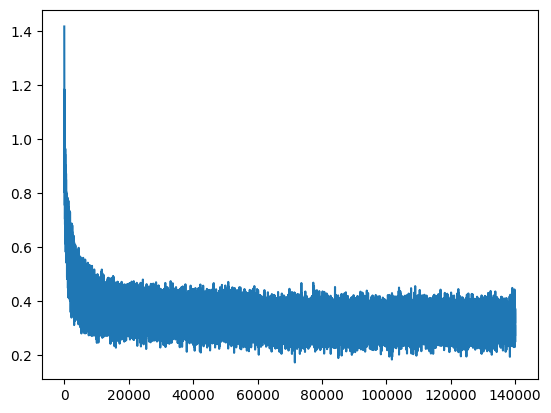

In [2]:
words = open('names.txt', 'r').read().splitlines()

lrlist = [[0.1,60000],[0.01,60000],[0.001,20000]]

Net = NeuralNet(200,15,64,lrlist,3,words)
Net.plot()
Net.generate(5)

### Ex2 - Fixing the initialization

1 - What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 

R: If the predicted probabilities at initialization were perfectly uniform we would get a loss of -log(1/27) = 3.30. Currently, we achieve an initial loss of 22.4

2 - Can you tune the initialization to get a starting loss that is much more similar to (1)?

R: Yes, this can be achieved by sampling the random initial weights as before, but multiplying all the last layer's weights by a lowering factor (and doing the same for the bias). This way, the logits wont be as big initialy and the train graph wont look as much like a hockey stick.

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

#This time, implementing a uniform loss initialization

class NeuralNet:

    def __init__(self, HidNeurons, EmbDim, batch_size, lrevolution, block_size, words):
        # mappings
        chars = sorted(list(set(''.join(words))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        # building the dataset
        def build_dataset(words):  
            X, Y = [], []
            for w in words:
                context = [0] * block_size
                for ch in w + '.':
                    ix = self.stoi[ch]
                    X.append(context)
                    Y.append(ix)
                    context = context[1:] + [ix] # crop and append
            X = torch.tensor(X)
            Y = torch.tensor(Y)
            return X, Y


        # splitting the data onto train, dev and test sets
        import random
        random.seed(42)
        random.shuffle(words)
        n1 = int(0.8*len(words))
        n2 = int(0.9*len(words))
        self.Xtr, self.Ytr = build_dataset(words[:n1])
        self.Xdev, self.Ydev = build_dataset(words[n1:n2])
        self.Xte, self.Yte = build_dataset(words[n2:])

        # initializing the neural net
        self.block_size = block_size
        self.g = torch.Generator().manual_seed(2147483647) # for reproducibility
        self.C = torch.randn((27, EmbDim), generator=self.g) # embedding matrix
        self.W1 = torch.randn((EmbDim*block_size, HidNeurons), generator=self.g)
        self.b1 = torch.randn(HidNeurons, generator=self.g)
        self.W2 = torch.randn((HidNeurons, 27), generator=self.g) * 0.01
        self.b2 = torch.randn(27, generator=self.g) * 0
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

        # training the neural net

        self.lossi = []
        self.stepi = []
        ref = 0

        def train(lr,epochs,ref):
            for i in range(epochs):
                ix = torch.randint(0, self.Xtr.shape[0], (batch_size,))

                # forward pass
                emb = self.C[self.Xtr[ix]] # (batch, block, Dim)
                h = torch.tanh(emb.view(-1, EmbDim*block_size) @ self.W1 + self.b1) # (batch, hid)
                logits = h @ self.W2 + self.b2 # (batch, 27)
                loss = F.cross_entropy(logits, self.Ytr[ix])
                
                if i == 1: print(f'Initial loss: {loss}')

                # backward pass
                for p in self.parameters:
                    p.grad = None
                loss.backward()
        
                for p in self.parameters:
                    p.data += -lr * p.grad

                self.stepi.append(ref+i)
                self.lossi.append(loss.log10().item())  
            ref += epochs
            return ref
        
        for run in lrevolution: ref = train(run[0],run[1],ref)
        
        emb = self.C[self.Xdev] # (batch, block, Dim)
        h = torch.tanh(emb.view(-1, EmbDim*block_size) @ self.W1 + self.b1) # (batch, hid)
        logits = h @ self.W2 + self.b2 # (batch, 27)
        devloss = F.cross_entropy(logits, self.Ydev)
        
        print('')
        print(f'Final Train Loss: {10**self.lossi[-1]}')
        print(f'Final Dev Loss: {devloss}')
    
    def plot(self):
        plt.plot(self.stepi,self.lossi)

    def generate(self,quant):
        print('')
        for _ in range(quant):
            out = []
            context = [0] * self.block_size # initialize with all ...
            while True:
                emb = self.C[torch.tensor([context])] # (1,block_size,d)
                h = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1)
                logits = h @ self.W2 + self.b2
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1, generator=self.g).item()
                context = context[1:] + [ix]
                out.append(ix)
                if ix == 0:
                    break
            print(''.join(self.itos[i] for i in out))
        print('')

Initial loss: 3.201413869857788
Initial loss: 2.083204507827759
Initial loss: 2.0954627990722656

Final Train Loss: 2.177536426885447
Final Dev Loss: 2.121150016784668

sho.
julyia.
likjeezin.
michosslioa.
arisharinrl.



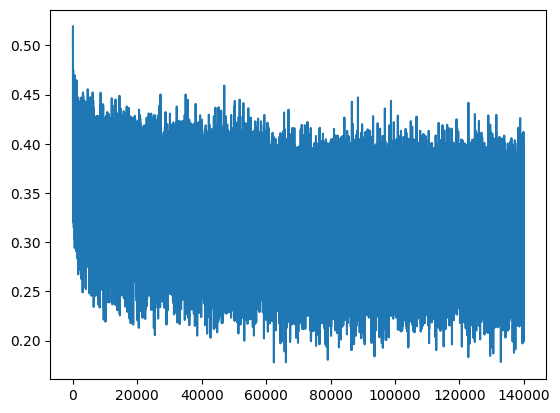

In [32]:
words = open('names.txt', 'r').read().splitlines()

lrlist = [[0.1,60000],[0.01,60000],[0.001,20000]]

Net = NeuralNet(200,15,64,lrlist,3,words)
Net.plot()
Net.generate(5)

### Ex3 - Implementing an idea from the sugested paper

In this exercise I am going to implement the sugested weight decay:

In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

#This time, implementing a uniform loss initialization

class NeuralNet:

    def __init__(self, HidNeurons, EmbDim, batch_size, lrevolution, block_size, words):
        # mappings
        chars = sorted(list(set(''.join(words))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        # building the dataset
        def build_dataset(words):  
            X, Y = [], []
            for w in words:
                context = [0] * block_size
                for ch in w + '.':
                    ix = self.stoi[ch]
                    X.append(context)
                    Y.append(ix)
                    context = context[1:] + [ix] # crop and append
            X = torch.tensor(X)
            Y = torch.tensor(Y)
            return X, Y


        # splitting the data onto train, dev and test sets
        import random
        random.seed(42)
        random.shuffle(words)
        n1 = int(0.8*len(words))
        n2 = int(0.9*len(words))
        self.Xtr, self.Ytr = build_dataset(words[:n1])
        self.Xdev, self.Ydev = build_dataset(words[n1:n2])
        self.Xte, self.Yte = build_dataset(words[n2:])

        # initializing the neural net
        self.block_size = block_size
        self.g = torch.Generator().manual_seed(2147483647) # for reproducibility
        self.C = torch.randn((27, EmbDim), generator=self.g) # embedding matrix
        self.W1 = torch.randn((EmbDim*block_size, HidNeurons), generator=self.g)
        self.b1 = torch.randn(HidNeurons, generator=self.g)
        self.W2 = torch.randn((HidNeurons, 27), generator=self.g) * 0.01
        self.b2 = torch.randn(27, generator=self.g) * 0
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

        # training the neural net

        self.lossi = []
        self.stepi = []
        ref = 0

        def train(lr,epochs,ref):
            for i in range(epochs):
                ix = torch.randint(0, self.Xtr.shape[0], (batch_size,))

                # forward pass
                emb = self.C[self.Xtr[ix]] # (batch, block, Dim)
                h = torch.tanh(emb.view(-1, EmbDim*block_size) @ self.W1 + self.b1) # (batch, hid)
                logits = h @ self.W2 + self.b2 # (batch, 27)
                loss = F.cross_entropy(logits, self.Ytr[ix])
                
                if i == 1: print(f'Initial loss: {loss}')

                # backward pass
                for p in self.parameters:
                    p.grad = None
                loss.backward()

                newlr = lr/(1+i*(10**(-4)))

                for p in self.parameters:
                    p.data += -newlr * p.grad

                self.stepi.append(ref+i)
                self.lossi.append(loss.log10().item())  
            ref += epochs
            return ref
        
        ref = train(lrevolution[0],lrevolution[1],ref)
        
        emb = self.C[self.Xdev] # (batch, block, Dim)
        h = torch.tanh(emb.view(-1, EmbDim*block_size) @ self.W1 + self.b1) # (batch, hid)
        logits = h @ self.W2 + self.b2 # (batch, 27)
        devloss = F.cross_entropy(logits, self.Ydev)
        
        print('')
        print(f'Final Train Loss: {10**self.lossi[-1]}')
        print(f'Final Dev Loss: {devloss}')
    
    def plot(self):
        plt.plot(self.stepi,self.lossi)

    def generate(self,quant):
        print('')
        for _ in range(quant):
            out = []
            context = [0] * self.block_size # initialize with all ...
            while True:
                emb = self.C[torch.tensor([context])] # (1,block_size,d)
                h = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1)
                logits = h @ self.W2 + self.b2
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1, generator=self.g).item()
                context = context[1:] + [ix]
                out.append(ix)
                if ix == 0:
                    break
            print(''.join(self.itos[i] for i in out))
        print('')

Initial loss: 3.1702051162719727

Final Train Loss: 1.8342210180056857
Final Dev Loss: 2.143306016921997

shoan.
ayia.
liah.
ozin.
michoston.



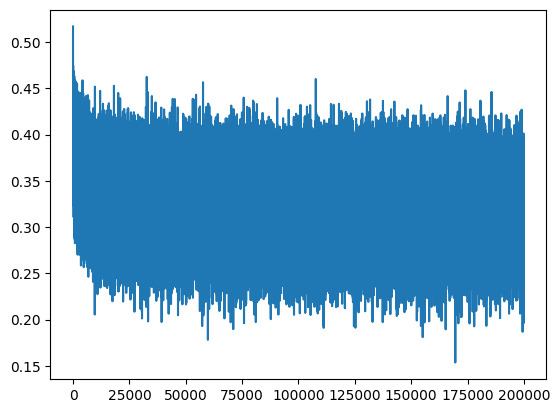

In [35]:
words = open('names.txt', 'r').read().splitlines()

Net = NeuralNet(200,15,64,[0.1,200000],3,words)
Net.plot()
Net.generate(5)

The net started to overfit, it would benefit from some type of regulization.